## Collective-RAG
- 기존의 Self-RAG 구조에 웹 검색 추가
- Tavily API 사용 

In [71]:
from dotenv import load_dotenv

load_dotenv()

True

In [72]:
from langchain_chroma import Chroma
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model='text-embedding-3-large')

# 기존에 생성한 vector store 불러오기 
vector_store = Chroma(
    embedding_function=embeddings,
    collection_name = 'income_tax_collection',
    persist_directory = '../income_tax_collection' #로컬에 영구 저장 버전 
)

In [73]:
retriever = vector_store.as_retriever(search_kwargs={'k': 3})

In [74]:
# State 정의 
from typing import Literal
from typing_extensions import List, TypedDict
from langchain_core.documents import Document

DOC_RELEVANCE_LITERAL = Literal["relevant", "irrelevant"]
HALLUCINATION_LITERAL = Literal["grounded", "hallucinated"]
HELPFULNESS_LITERAL = Literal["helpful", "unhelpful"] 

class AgentState(TypedDict):
    original_query: str
    query: str
    
    context: List[Document]
    answer: str

    # 검증 결과 
    doc_relevance_status: DOC_RELEVANCE_LITERAL
    hallucination_status: HALLUCINATION_LITERAL
    helpfulness_status: HELPFULNESS_LITERAL

    # 검증 시도 횟수 
    rewrite_count: int      # 질문 재작성 시도 횟수 (Max 3번)
    generation_count: int   # LLM 답변 생성 시도 횟수 (재생성 Max 2번)
    search_count: int      # 웹 검색 시도 횟수 (Max 1번)

In [75]:
# Node 정의
# 사용자 query로 vector store에서 검색을 수행하는 노드 
def retrieve(state: AgentState) -> AgentState:
    query = state['query']
    
    docs = retriever.invoke(query)

    # 메타데이터에 "category" 추가, "source"는 원본 문서 경로
    for doc in docs:
        doc.metadata["category"] = "vector_store"

    return {'context': docs}

In [76]:
from langchain_openai import ChatOpenAI
from langsmith import Client

llm = ChatOpenAI(model='gpt-4o')
client = Client()

In [77]:
# context와 query를 받아서 LLM 답변을 생성하는 노드 
def generate(state: AgentState) -> AgentState:
    context = state['context']
    query = state['query']
    
    prompt = client.pull_prompt("rlm/rag-prompt")
    rag_chain = prompt | llm
    response = rag_chain.invoke({'question': query, 'context': context})

    return {'answer': response.content, 'generation_count': state['generation_count'] + 1}

In [78]:
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser

# 검색 결과의 정확도를 높이도록 사용자 쿼리를 변환하는 노드 
def rewrite(state: AgentState) -> AgentState:
    
    query = state['query']
    dictionary = ["사람을 나타내는 표현 -> 거주자"]

    keyword_dictionary_prompt = PromptTemplate.from_template(
        f"""사용자의 질문을 보고, 키워드 사전을 참고해서 사용자의 질문을 변경해주세요. 
        사전: {dictionary}
        사용자의 질문: {{question}}
        """
    )
    keyword_dictionary_chain = keyword_dictionary_prompt| llm | StrOutputParser()
    rewritten_query = keyword_dictionary_chain.invoke({'question': query})

    return {'query': rewritten_query, 'rewrite_count': state['rewrite_count'] + 1}

In [79]:
validation_llm = ChatOpenAI(model="gpt-4o", temperature=0)

In [80]:
# retriver에서 검색한 문서의 관련성을 판단하는 노드 
def check_doc_relevance(state: AgentState):
    query = state['query'] 
    context = state['context'] 

    doc_relevance_prompt = client.pull_prompt("rlm/rag-document-relevance")

    doc_relevance_chain = doc_relevance_prompt | validation_llm

    response = doc_relevance_chain.invoke({
        "input": {
            "question": query,
            "documents": context
        }
    })
    
    # doc_relevance_chain의 결과: 문서 관련성이 높으면 1, 아니면 0 
    if response['Score'] == 1:
        return {"doc_relevance_status": "relevant"}
    else:
        return {"doc_relevance_status": "irrelevant"}

def get_doc_relevance_status(state: AgentState):
    if state['rewrite_count'] > 3: #3번 넘게 재작성 시도 시 종료
        return "count_limit"
    return state["doc_relevance_status"]

In [81]:
# 할루시네이션 검증 노드  
def check_hallucination(state: AgentState):
    context = state["context"]
    answer = state["answer"]

    hallucination_prompt = PromptTemplate.from_template("""
    당신은 학생의 답변이 제공된 문서(법령)에 기반하고 있는지 평가하는 엄격한 선생님입니다. 
    제공된 문서 내용과 학생의 답변을 비교하여 아래 기준에 따라 판결해주세요. 

    [평가 기준]
    1. 학생의 답변이 문서에 있는 내용과 일치하거나, 문서에 근거하여 작성되었다면 "grounded"라고 응답.
    2. 학생이 "문서에서 관련 정보를 찾을 수 없다"거나 "내용이 언급되지 않았다"고 사실대로 말한 경우, 이는 거짓말이 아니므로 "grounded"로 간주.
    3. 문서에 없는 고유명사, 숫자, 날짜 등을 마치 문서에 있는 것처럼 지어내서 답변했다면 "hallucinated"라고 응답.
    4. 문서 내용과 정면으로 반대되는 주장을 한다면 "hallucinated"라고 응답. 

    답변은 반드시 "grounded" 또는 "hallucinated" 중 하나로만 대답해.

    문서(Documents): {documents}
    학생 답변(Student Answer): {student_answer}
    """
)

    hallucinations_chain = hallucination_prompt | validation_llm | StrOutputParser()
    
    # 평가 실행
    response = hallucinations_chain.invoke({
        "documents": context,
        "student_answer": answer 
    })

    # 판단 결과를 State에 업데이트합니다.
    return {"hallucination_status": response}

def get_hallucination_status(state: AgentState):
    if state['generation_count'] > 3: # 2번이상 재작성시 종료 (초기 1번은 재작성이 아니므로 제외)
        return "count_limit"
    return state["hallucination_status"]

In [82]:
# 유용성 검증 노드 
from langgraph.graph import END

def check_helpfulness(state:AgentState):
    query = state['query']
    answer = state['answer']

    helpfulness_prompt = PromptTemplate.from_template("""
    당신은 제공된 답변이 사용자의 질문에 대해 '실질적인 정보'를 제공했는지 판별하는 엄격한 평가관입니다. 
    아래 기준에 따라 "helpful" 또는 "unhelpful"로 대답해주세요.

    [판별 기준]
    1. **"helpful"**: 사용자의 질문에 대한 **직접적인 정답이나 구체적인 수치, 실행 방법**이 포함되어 있어야 해.
    2. **"unhelpful"**: 아래 중 하나라도 해당하면 무조건 "unhelpful"이야.
       - "문서에서 정보를 찾을 수 없다"고 답변하는 경우.
       - "알 수 없다"거나 "확인할 수 없다"고 답변하는 경우.
       - "전문가에게 문의하라"는 식의 원론적인 조언만 하는 경우.
       - 질문은 구체적인데 답변은 "관련 내용이 없다"는 식의 회피성 답변인 경우.

    사용자의 질문: {question}
    AI의 답변: {answer}

    결과는 오직 "helpful" 또는 "unhelpful" 중 하나로만 말해주세요. 
    """
)
    helpfulness_chain = helpfulness_prompt | validation_llm | StrOutputParser()
    
    # 평가 실행
    response = helpfulness_chain.invoke({
        "question": query,
        "answer": answer 
    })
    return {"helpfulness_status": response}

def get_helpfulness_status(state: AgentState):
    if state['search_count'] >= 1: #1번 웹 검색 시도 시 종료
        return "count_limit"
    return state["helpfulness_status"]

In [83]:

def inform_failure(state: AgentState) -> AgentState:
    # 기존에 생성되었던 답변(정직한 거절 답변 등)을 가져옵니다.
    existing_answer = state.get("answer", "관련 정보를 찾을 수 없습니다.")
    
    # 실패 안내 메시지를 조금 더 전문적으로 구성합니다.
    failure_message = (
        f"--- [최종 확인 결과] ---\n"
        f"{existing_answer}\n\n"
        f"------------------------\n"
        f"💡 안내: 내부 문서와 최신 웹 검색을 모두 확인했으나, 질문에 대한 더 구체적인 확답을 드리기 어려운 상태입니다. "
        f"질문을 조금 더 구체적으로(예: 연도, 특정 상황 등) 바꿔서 다시 물어봐 주시면 감사하겠습니다."
    )
    
    return {"answer": failure_message}

In [84]:
# 사용자 쿼리를 웹 검색에 적합하도록 변환하는 노드 
def web_search_rewrite(state: AgentState) -> AgentState:
    original_query = state['original_query'] #사용자 원본 질문 사용 
    
    web_search_rewrite_prompt = PromptTemplate.from_template(
        f""" 아래 질문을 웹 검색에서 가장 최신의 정확한 정보를 찾을 수 있는 검색어로 변환해주세요. 
        사용자 질문: {original_query}
        """
    )
    web_search_rewrite_chain = web_search_rewrite_prompt | llm | StrOutputParser()
    rewritten_query = web_search_rewrite_chain.invoke({'original_query': original_query})

    return {'query': rewritten_query, 'generation_count': 0}

In [85]:
from langchain_tavily import TavilySearch

tavily_search_tool = TavilySearch(
    max_results=3, # 디폴트 5 
    search_depth="advanced" # 디폴트 "basic"
)

In [86]:
#web_results = tavily_search_tool.invoke("봉천동 양꼬치 맛집 추천 리스트 블로그 포스팅 맛 평가")

In [87]:
# Tavily API 결과 구조 확인 (json 형식)
#print(web_results)

In [88]:
def web_search(state: AgentState) -> AgentState:
    # 1. 기존 context 가져오기
    existing_context = state.get('context', [])
    
    # 2. 웹 검색 수행 
    query = state['query']
    web_results = tavily_search_tool.invoke(query)
    
    # 3. 검색 결과를 metadata가 포함된 Document 객체로 변환
    new_docs = []
    for result in web_results["results"]:
        full_content = f"제목: {result.get('title', '')}\n내용: {result.get('content', '')}"
        doc = [
            Document(
                page_content=full_content,
                metadata={
                    "category": "web_search", 
                    "source": result.get("url", "unknown"),
                    "score": result.get("score", 0)
                }
            ) 
        ]
        new_docs.append(doc)
    
    # 4. 기존 context 뒤에 새 정보 붙이기
    return {"context": existing_context + new_docs, 'search_count': state['search_count'] + 1}

In [89]:
from langgraph.graph import StateGraph, START, END

#  그래프 빌더 생성 
graph_builder = StateGraph(AgentState)

# 노드 추가 
graph_builder.add_node("retrieve", retrieve)
graph_builder.add_node("generate", generate)
graph_builder.add_node("rewrite", rewrite)

graph_builder.add_node("check_doc_relevance", check_doc_relevance)
graph_builder.add_node("check_hallucination", check_hallucination)
graph_builder.add_node("check_helpfulness", check_helpfulness)
graph_builder.add_node("inform_failure", inform_failure)

graph_builder.add_node("web_search_rewrite", web_search_rewrite)
graph_builder.add_node("web_search", web_search)


In [90]:
from langgraph.graph import StateGraph, START, END
# 엣지 추가 
graph_builder.add_edge(START, "retrieve")
graph_builder.add_edge("retrieve", "check_doc_relevance")
graph_builder.add_edge('rewrite', 'retrieve')
graph_builder.add_edge("generate", "check_hallucination")
graph_builder.add_edge("inform_failure", END)

graph_builder.add_conditional_edges(
    "check_doc_relevance",
    get_doc_relevance_status,
    {
        "relevant": "generate",
        "irrelevant": "rewrite",
        "count_limit": "inform_failure"
     }
)

graph_builder.add_conditional_edges(
    "check_hallucination",
    get_hallucination_status,
    {
        "grounded": "check_helpfulness",
        "hallucinated": "generate",
        "count_limit": "inform_failure"
    }
)

graph_builder.add_conditional_edges(
    "check_helpfulness",
    get_helpfulness_status,
    {
        "helpful": END,
        "unhelpful": "web_search_rewrite",
        "count_limit": "inform_failure"
    }
)

graph_builder.add_edge("web_search_rewrite", "web_search")
graph_builder.add_edge("web_search", "generate")

In [91]:
# 그래프 생성 
graph = graph_builder.compile() 

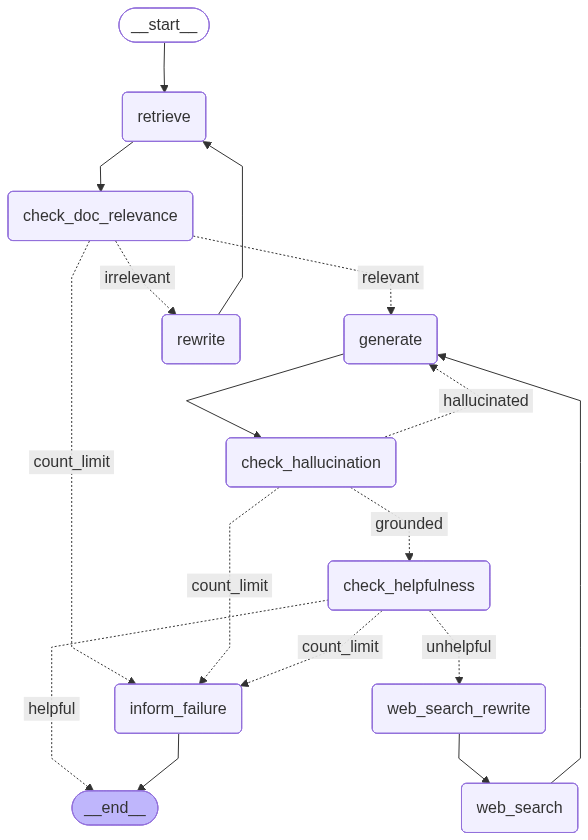

In [92]:
# 그래프 시각화 
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [93]:
# 그래프 실행 
#user_query = '연봉 5000만원인 거주자의 소득세는 얼마인가요?'
#user_query = '연봉 5천만원 세금'
#user_query = '연봉 8000만 원인 외벌이 가구가 신용카드로 3000만 원 썼을 때, 올해 카드 공제액이 얼마인지 예시로 계산해줘.'
user_query = "소득세법 제70조에 따른 거주자 종합소득 과세표준을 계산할 때, 2026년에 새로 도입되는 AI 특별 공제 항목도 포함해야 하나요?"
initial_state = {'original_query': user_query, 'query': user_query, 'generation_count': 0, 'rewrite_count': 0, 'search_count': 0} #초기값 0
result = graph.invoke(initial_state)

print(result['answer'])

--- [최종 확인 결과] ---
현재 제공된 문서 내에서는 2026년 소득세법 제70조와 관련하여 AI 특별 공제가 거주자의 종합소득 과세표준에 포함되는지 여부에 대한 명확한 정보가 없습니다. 소득세법과 관련 특별 공제에 대한 명확한 내용은 확인되지 않았습니다. 구체적인 법적 세부사항은 최신 법률 문서나 세무 전문가의 상담을 통해 확인해야 합니다.

------------------------
💡 안내: 내부 문서와 최신 웹 검색을 모두 확인했으나, 질문에 대한 더 구체적인 확답을 드리기 어려운 상태입니다. 질문을 조금 더 구체적으로(예: 연도, 특정 상황 등) 바꿔서 다시 물어봐 주시면 감사하겠습니다.
